
Import  package

In [1]:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from qcat.visualization.readout_fidelity import plot_readout_fidelity
from qcat.analysis.state_discrimination.readout_fidelity import GMMROFidelity
from qcat.analysis.state_discrimination import p01_to_Teff


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


File formate translate (QM)

In [2]:
dataset = xr.open_dataset(r"d:\Data\Qubit\5Q4C0510_DR1_scalinQ\20240617_1010_ro_fidelity_q4_xy.nc")
print(dataset)
transposed_data = dataset.transpose("mixer", "state", "index")

format_data = {}
for ro_name, data in transposed_data.data_vars.items(): 
    new_data = data.values*1000
    format_data[ro_name] = new_data
    print(ro_name)


<xarray.Dataset> Size: 2MB
Dimensions:  (mixer: 2, index: 10000, state: 2)
Coordinates:
  * mixer    (mixer) <U1 8B 'I' 'Q'
  * index    (index) int32 40kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * state    (state) int32 8B 0 1
Data variables:
    q0_ro    (mixer, index, state) float64 320kB ...
    q1_ro    (mixer, index, state) float64 320kB ...
    q2_ro    (mixer, index, state) float64 320kB ...
    q3_ro    (mixer, index, state) float64 320kB ...
    q4_ro    (mixer, index, state) float64 320kB ...
q0_ro
q1_ro
q2_ro
q3_ro
q4_ro


File formate translate (Qblox)

In [3]:
# dataset = xr.open_dataset(r"D:\Data\format_test\DR1q0_SingleShot_44GHz.nc")
# # print(dataset)
# shot_num = dataset["g"].values.shape[-1]
# combined_array = np.array([dataset["g"].values,dataset["e"].values])
# format_dataset = xr.Dataset(
#     {"q0_ro":(["state", "mixer", "index"], combined_array)},
#     coords={ "mixer":np.array(["I","Q"]), "state":np.array([0,1]), "index": np.arange(shot_num) }
# )
# format_dataset = format_dataset.transpose("mixer", "state", "index")

# print(format_dataset)

# format_data = {}
# format_data["q0_ro"] = format_dataset["q0_ro"].values*1000



Create Discriminator object to analyze data

In [6]:


# Prepare data
ro_name = "q4_ro"
training_data = format_data[ro_name] #your (2,2,N) data to train
dataset = xr.DataArray(training_data, coords= [("mixer",["I","Q"]), ("prepared_state",[0,1]), ("index",np.arange(data.shape[2]))] )
# print(dataset)

# Do analysis
gmm2d_fidelity = GMMROFidelity()
gmm2d_fidelity._import_data(dataset)
gmm2d_fidelity._start_analysis()
g1d_fidelity = gmm2d_fidelity.export_G1DROFidelity()

# Get parameters
prepare_state = list(dataset.coords["prepared_state"].values)
print( f"prepare {prepare_state}")

for i in prepare_state:
    print(f"prepare {i} state")
    print(f"GMM threshold")
    gmm2d_prob = gmm2d_fidelity.state_probability[i]
    print(f"p{i}0={gmm2d_prob[0]}")
    print(f"p{i}1={gmm2d_prob[1]}")

    print(f"Gaussian fiting")
    g1d_prob, bin_center, hist, fit_result = g1d_fidelity.g1d_dist[i]
    print(f"p{i}0={g1d_prob[0]}")
    print(f"p{i}1={g1d_prob[1]}")

    print(f"signal:{g1d_fidelity.discriminator.signal}")
    print(f"noise:{g1d_fidelity.discriminator.noise}")
    print(f"snr:{g1d_fidelity.discriminator.snr}")

effective_T = p01_to_Teff(g1d_fidelity.g1d_dist[0][0][1], 4e9)
print(effective_T)
# For loop end here


prepare [0, 1]
prepare 0 state
GMM threshold
p00=0.8969
p01=0.1031
Gaussian fiting
p00=0.8961799771933682
p01=0.10382002280663186
signal:0.12667870257719255
noise:[0.02381419 0.02455851]
snr:5.237611354322708
prepare 1 state
GMM threshold
p10=0.1193
p11=0.8807
Gaussian fiting
p10=1.001006696605257
p11=-0.0010066966052571966
signal:0.12667870257719255
noise:[0.02381419 0.02455851]
snr:5.237611354322708
0.0890666821323737


Plot fidelity

(2, 2, 10000)
<xarray.DataArray (mixer: 2, prepared_state: 2, index: 10000)> Size: 320kB
array([[[-0.05065277, -0.08935481, -0.009574  , ...,  0.05174801,
         -0.03048033,  0.05506724],
        [ 0.09947643,  0.0645332 , -0.09682775, ...,  0.05608425,
          0.05859882, -0.07339194]],

       [[-0.04452839, -0.02836436, -0.08781999, ..., -0.07515028,
         -0.08118153, -0.12604892],
        [-0.11435896, -0.07732585, -0.09975582, ..., -0.09478256,
         -0.06330013, -0.07201731]]])
Coordinates:
  * mixer           (mixer) <U1 8B 'I' 'Q'
  * prepared_state  (prepared_state) int32 8B 0 1
  * index           (index) int32 40kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999


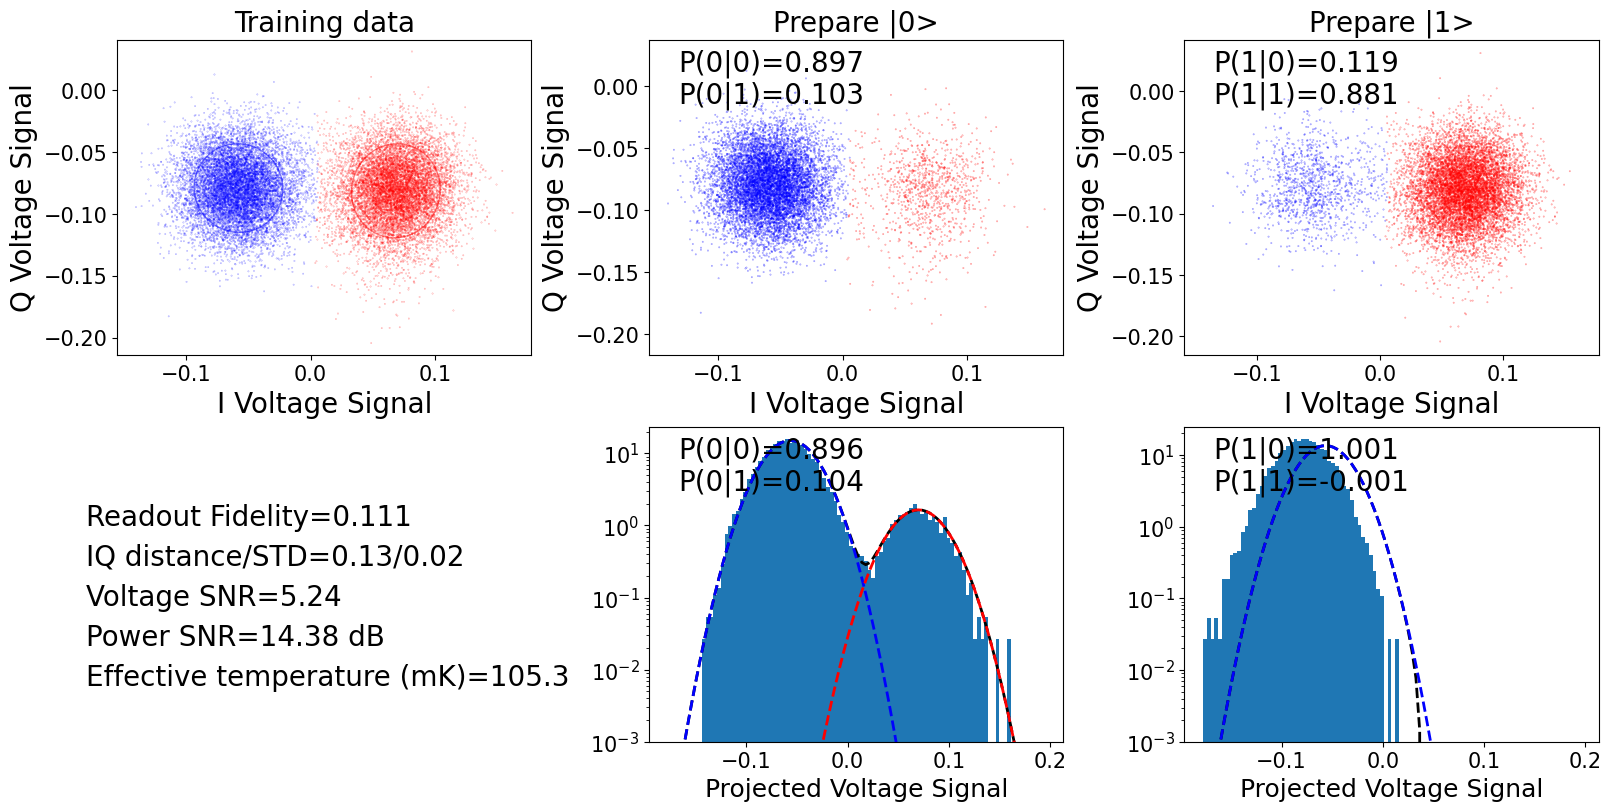

In [5]:

single_name = ro_name
# for ro_name, data in format_data.items(): 
for ro_name, data in [(single_name, format_data[single_name])]:
    print(data.shape)
    dataset = xr.DataArray(training_data, coords= [("mixer",["I","Q"]), ("prepared_state",[0,1]), ("index",np.arange(data.shape[2]))] )
    print(dataset)

    # Do analysis
    gmm2d_fidelity = GMMROFidelity()
    gmm2d_fidelity._import_data(dataset)
    gmm2d_fidelity._start_analysis()
    g1d_fidelity = gmm2d_fidelity.export_G1DROFidelity()
    
    plot_readout_fidelity( dataset, gmm2d_fidelity, g1d_fidelity, 4.73e9 )

plt.show()
